In [1]:
from ipynb.fs.defs.cml_functions import *
from time import sleep

In [5]:
def cml_analyse(path,plot_save_path='cm_analysis/',search_radius=2):
    name = os.path.basename(os.path.splitext(path)[0])
    data = open_cm_log(path)
    # STEP 1: Rough geographic selection 
    position_list = extract_json_positions(data)
    positions_city = get_points_in_circle(position_list,get_hamburg_center())
    # Second round
    median = np.median(positions_city,axis=0)
    p0 = get_points_in_circle(positions_city, median, radius_km=search_radius)

    plt.plot(median[1],median[0],'xr',ms=20)
    plt.plot(p0[:,1],p0[:,0],'.') #plot longitude, latitude
    mplleaflet.display()
    # STEP 2: Filter points belonging to train
    p1=filter_train(p0)
    # STEP 3: Sort out outliers within train by taking median of 3 neighboring points
    p1_avg =  median_with_nearest(p1,n=3)
    # STEP 4: Sort points
    p2 = sort_points(p1_avg)
    # STEP 5: Snap points to road
    match0NoLoop,match0Unique = osrm_match(p2[:,:])
    
    # Create result plot
    plt.plot(positions_city[:,1],positions_city[:,0],'b.')
    plt.plot(p0[:,1],p0[:,0], 'xk')
    plt.plot(p2[:,1],p2[:,0], 'ok')
    # print('With loops:',getPathLength(match0Unique))
    # print('Loops removed:',getPathLength(match0NoLoop))
    plt.plot(match0Unique[:,1],match0Unique[:,0],'b-')
    plt.plot(match0NoLoop[:,1],match0NoLoop[:,0],'r-',linewidth=3)
    #mplleaflet.display(fig=f)
    mplleaflet_update(path=os.path.join(plot_save_path,name+'.html'))
    results = dict()
    results['p0'] = p0
    results['p1'] = p1
    results['p1_avg'] = p1_avg
    results['p2'] = p2
    results['length'] = getPathLength(match0NoLoop)
    return results

#cml_analyse('cm_logs/20220624_210255.txt')
#results = cml_analyse('cm_logs/20220624_203957.txt')
results = cml_analyse('cm_logs/20220624_215158.txt')

C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


In [6]:
name_list = []
length_list = []
for ii,entry in enumerate(os.scandir('cm_logs')):
    if ii%5==0:
        if entry.path.endswith(".txt"):
            print(entry.path)
            result = cml_analyse(entry.path)
            print(result['length'])
            name_list.append(entry.name)
            length_list.append(result['length'])
            sleep(1)

cm_logs\20220624_202509.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


2044.8983335798464
cm_logs\20220624_202644.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


2308.289905898358
cm_logs\20220624_202735.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


2497.725246389616
cm_logs\20220624_202827.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


2896.377251497851
cm_logs\20220624_202929.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


2683.056331837286
cm_logs\20220624_203021.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


( 12 - 13 ) and ( 22 - 23 ) Crossed intersection; inLoop= True
( 22 - 23 ) and ( 12 - 13 ) Crossed intersection; inLoop= False
3402.2306928448934
cm_logs\20220624_203113.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


2266.8385580168533
cm_logs\20220624_203206.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


2035.7968503296484
cm_logs\20220624_203258.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


( 28 - 29 ) and ( 30 - 31 ) Crossed intersection; inLoop= True
( 30 - 31 ) and ( 28 - 29 ) Crossed intersection; inLoop= False
2158.35432901997
cm_logs\20220624_203350.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


2324.486435127233
cm_logs\20220624_203442.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


2111.4986691672875
cm_logs\20220624_203535.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


1380.6351612670444
cm_logs\20220624_203627.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


1564.684937443543
cm_logs\20220624_203719.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


1832.7862711802939
cm_logs\20220624_203812.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


1744.7445919258603
cm_logs\20220624_203904.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


1536.7642560498502
cm_logs\20220624_203957.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


1713.0318437005599
cm_logs\20220624_204049.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


1830.609546441018
cm_logs\20220624_204141.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


( 21 - 22 ) and ( 31 - 32 ) Crossed intersection; inLoop= True
( 31 - 32 ) and ( 21 - 22 ) Crossed intersection; inLoop= False
2946.2920828351057
cm_logs\20220624_204234.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


( 1 - 2 ) and ( 4 - 5 ) Crossed intersection; inLoop= True
( 4 - 5 ) and ( 1 - 2 ) Crossed intersection; inLoop= False
2297.5236404563807
cm_logs\20220624_204326.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


( 15 - 16 ) and ( 25 - 26 ) Crossed intersection; inLoop= True
( 25 - 26 ) and ( 15 - 16 ) Crossed intersection; inLoop= False
( 25 - 26 ) and ( 23 - 24 ) Crossed intersection; inLoop= True
( 48 - 49 ) and ( 40 - 41 ) Crossed intersection; inLoop= False
3946.7801555229967
cm_logs\20220624_204418.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


( 8 - 9 ) and ( 14 - 15 ) Crossed intersection; inLoop= True
( 14 - 15 ) and ( 8 - 9 ) Crossed intersection; inLoop= False
( 15 - 16 ) and ( 20 - 21 ) Crossed intersection; inLoop= True
( 15 - 16 ) and ( 21 - 22 ) Crossed intersection; inLoop= False
3766.8498700943956
cm_logs\20220624_204511.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


( 13 - 14 ) and ( 21 - 22 ) Crossed intersection; inLoop= True
( 21 - 22 ) and ( 13 - 14 ) Crossed intersection; inLoop= False
4339.039442688466
cm_logs\20220624_204603.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


1723.506485376225
cm_logs\20220624_204655.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


( 13 - 14 ) and ( 23 - 24 ) Crossed intersection; inLoop= True
( 21 - 22 ) and ( 16 - 17 ) Crossed intersection; inLoop= False
2272.608251175772
cm_logs\20220624_204747.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


1825.0833577786298
cm_logs\20220624_204839.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


( 3 - 4 ) and ( 20 - 21 ) Crossed intersection; inLoop= True
( 3 - 4 ) and ( 21 - 22 ) Crossed intersection; inLoop= False
( 4 - 5 ) and ( 17 - 18 ) Crossed intersection; inLoop= True
( 4 - 5 ) and ( 21 - 22 ) Crossed intersection; inLoop= False
( 5 - 6 ) and ( 21 - 22 ) Crossed intersection; inLoop= True
( 14 - 15 ) and ( 6 - 7 ) Crossed intersection; inLoop= False
( 17 - 18 ) and ( 21 - 22 ) Crossed intersection; inLoop= True
( 20 - 21 ) and ( 3 - 4 ) Crossed intersection; inLoop= False
( 24 - 25 ) and ( 39 - 40 ) Crossed intersection; inLoop= True
( 39 - 40 ) and ( 9 - 10 ) Crossed intersection; inLoop= False
( 39 - 40 ) and ( 10 - 11 ) Crossed intersection; inLoop= True
( 39 - 40 ) and ( 24 - 25 ) Crossed intersection; inLoop= False
1725.0155755091046
cm_logs\20220624_204938.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


1285.239653898589
cm_logs\20220624_205030.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


( 0 - 1 ) and ( 14 - 15 ) Crossed intersection; inLoop= True
( 12 - 13 ) and ( 6 - 7 ) Crossed intersection; inLoop= False
( 12 - 13 ) and ( 7 - 8 ) Crossed intersection; inLoop= True
( 13 - 14 ) and ( 6 - 7 ) Crossed intersection; inLoop= False
( 20 - 21 ) and ( 28 - 29 ) Crossed intersection; inLoop= True
( 20 - 21 ) and ( 30 - 31 ) Crossed intersection; inLoop= False
( 20 - 21 ) and ( 31 - 32 ) Crossed intersection; inLoop= True
( 20 - 21 ) and ( 32 - 33 ) Crossed intersection; inLoop= False
( 21 - 22 ) and ( 24 - 25 ) Crossed intersection; inLoop= True
( 21 - 22 ) and ( 28 - 29 ) Crossed intersection; inLoop= False
( 23 - 24 ) and ( 32 - 33 ) Crossed intersection; inLoop= True
( 24 - 25 ) and ( 21 - 22 ) Crossed intersection; inLoop= False
( 45 - 46 ) and ( 51 - 52 ) Crossed intersection; inLoop= True
( 51 - 52 ) and ( 45 - 46 ) Crossed intersection; inLoop= False
3456.3211858028662
cm_logs\20220624_205123.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


( 9 - 10 ) and ( 15 - 16 ) Crossed intersection; inLoop= True
( 15 - 16 ) and ( 9 - 10 ) Crossed intersection; inLoop= False
( 26 - 27 ) and ( 29 - 30 ) Crossed intersection; inLoop= True
( 26 - 27 ) and ( 34 - 35 ) Crossed intersection; inLoop= False
( 26 - 27 ) and ( 35 - 36 ) Crossed intersection; inLoop= True
( 26 - 27 ) and ( 36 - 37 ) Crossed intersection; inLoop= False
( 27 - 28 ) and ( 36 - 37 ) Crossed intersection; inLoop= True
( 29 - 30 ) and ( 26 - 27 ) Crossed intersection; inLoop= False
( 34 - 35 ) and ( 36 - 37 ) Crossed intersection; inLoop= True
( 35 - 36 ) and ( 26 - 27 ) Crossed intersection; inLoop= False
3300.1032823337937
cm_logs\20220624_205216.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


( 2 - 3 ) and ( 26 - 27 ) Crossed intersection; inLoop= True
( 20 - 21 ) and ( 15 - 16 ) Crossed intersection; inLoop= False
( 31 - 32 ) and ( 50 - 51 ) Crossed intersection; inLoop= True
( 45 - 46 ) and ( 32 - 33 ) Crossed intersection; inLoop= False
2482.0714853037866
cm_logs\20220624_205308.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


( 3 - 4 ) and ( 28 - 29 ) Crossed intersection; inLoop= True
( 23 - 24 ) and ( 17 - 18 ) Crossed intersection; inLoop= False
( 33 - 34 ) and ( 36 - 37 ) Crossed intersection; inLoop= True
( 36 - 37 ) and ( 33 - 34 ) Crossed intersection; inLoop= False
2168.0337043427376
cm_logs\20220624_205400.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


( 3 - 4 ) and ( 7 - 8 ) Crossed intersection; inLoop= True
( 7 - 8 ) and ( 3 - 4 ) Crossed intersection; inLoop= False
1850.930411078331
cm_logs\20220624_205453.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


( 9 - 10 ) and ( 32 - 33 ) Crossed intersection; inLoop= True
( 27 - 28 ) and ( 21 - 22 ) Crossed intersection; inLoop= False
2728.424192382431
cm_logs\20220624_205545.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


( 10 - 11 ) and ( 37 - 38 ) Crossed intersection; inLoop= True
( 19 - 20 ) and ( 14 - 15 ) Crossed intersection; inLoop= False
( 28 - 29 ) and ( 33 - 34 ) Crossed intersection; inLoop= True
( 28 - 29 ) and ( 34 - 35 ) Crossed intersection; inLoop= False
( 29 - 30 ) and ( 33 - 34 ) Crossed intersection; inLoop= True
( 33 - 34 ) and ( 28 - 29 ) Crossed intersection; inLoop= False
( 33 - 34 ) and ( 29 - 30 ) Crossed intersection; inLoop= True
( 34 - 35 ) and ( 28 - 29 ) Crossed intersection; inLoop= False
( 42 - 43 ) and ( 47 - 48 ) Crossed intersection; inLoop= True
( 47 - 48 ) and ( 42 - 43 ) Crossed intersection; inLoop= False
2827.598444959793
cm_logs\20220624_205637.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


( 12 - 13 ) and ( 34 - 35 ) Crossed intersection; inLoop= True
( 30 - 31 ) and ( 24 - 25 ) Crossed intersection; inLoop= False
( 52 - 53 ) and ( 57 - 58 ) Crossed intersection; inLoop= True
( 57 - 58 ) and ( 52 - 53 ) Crossed intersection; inLoop= False
3919.6483029865067
cm_logs\20220624_205729.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


( 11 - 12 ) and ( 26 - 27 ) Crossed intersection; inLoop= True
( 25 - 26 ) and ( 19 - 20 ) Crossed intersection; inLoop= False
1447.2699989347507
cm_logs\20220624_205822.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


( 12 - 13 ) and ( 18 - 19 ) Crossed intersection; inLoop= True
( 17 - 18 ) and ( 13 - 14 ) Crossed intersection; inLoop= False
2240.1450685616746
cm_logs\20220624_205914.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


2422.7947707150506
cm_logs\20220624_210006.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


( 4 - 5 ) and ( 8 - 9 ) Crossed intersection; inLoop= True
( 8 - 9 ) and ( 4 - 5 ) Crossed intersection; inLoop= False
( 14 - 15 ) and ( 17 - 18 ) Crossed intersection; inLoop= True
( 17 - 18 ) and ( 14 - 15 ) Crossed intersection; inLoop= False
2225.1573196112026
cm_logs\20220624_210059.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


( 12 - 13 ) and ( 14 - 15 ) Crossed intersection; inLoop= True
( 14 - 15 ) and ( 12 - 13 ) Crossed intersection; inLoop= False
( 20 - 21 ) and ( 32 - 33 ) Crossed intersection; inLoop= True
( 32 - 33 ) and ( 20 - 21 ) Crossed intersection; inLoop= False
3146.799243222592
cm_logs\20220624_210152.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


( 15 - 16 ) and ( 17 - 18 ) Crossed intersection; inLoop= True
( 17 - 18 ) and ( 15 - 16 ) Crossed intersection; inLoop= False
5047.678839883629
cm_logs\20220624_210244.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


2551.887611323079
cm_logs\20220624_210336.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


( 0 - 1 ) and ( 12 - 13 ) Crossed intersection; inLoop= True
( 12 - 13 ) and ( 0 - 1 ) Crossed intersection; inLoop= False
1533.4133621893782
cm_logs\20220624_210428.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


( 7 - 8 ) and ( 25 - 26 ) Crossed intersection; inLoop= True
( 7 - 8 ) and ( 27 - 28 ) Crossed intersection; inLoop= False
( 30 - 31 ) and ( 33 - 34 ) Crossed intersection; inLoop= True
( 33 - 34 ) and ( 30 - 31 ) Crossed intersection; inLoop= False
( 34 - 35 ) and ( 40 - 41 ) Crossed intersection; inLoop= True
( 40 - 41 ) and ( 34 - 35 ) Crossed intersection; inLoop= False
( 41 - 42 ) and ( 43 - 44 ) Crossed intersection; inLoop= True
( 41 - 42 ) and ( 44 - 45 ) Crossed intersection; inLoop= False
( 42 - 43 ) and ( 45 - 46 ) Crossed intersection; inLoop= True
( 43 - 44 ) and ( 41 - 42 ) Crossed intersection; inLoop= False
3415.0626390485772
cm_logs\20220624_210521.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


( 8 - 9 ) and ( 12 - 13 ) Crossed intersection; inLoop= True
( 8 - 9 ) and ( 13 - 14 ) Crossed intersection; inLoop= False
( 9 - 10 ) and ( 13 - 14 ) Crossed intersection; inLoop= True
( 9 - 10 ) and ( 16 - 17 ) Crossed intersection; inLoop= False
( 9 - 10 ) and ( 18 - 19 ) Crossed intersection; inLoop= True
( 12 - 13 ) and ( 8 - 9 ) Crossed intersection; inLoop= False
( 13 - 14 ) and ( 19 - 20 ) Crossed intersection; inLoop= True
( 13 - 14 ) and ( 20 - 21 ) Crossed intersection; inLoop= False
( 13 - 14 ) and ( 24 - 25 ) Crossed intersection; inLoop= True
( 13 - 14 ) and ( 25 - 26 ) Crossed intersection; inLoop= False
( 15 - 16 ) and ( 22 - 23 ) Crossed intersection; inLoop= True
( 15 - 16 ) and ( 24 - 25 ) Crossed intersection; inLoop= False
( 15 - 16 ) and ( 25 - 26 ) Crossed intersection; inLoop= True
( 16 - 17 ) and ( 9 - 10 ) Crossed intersection; inLoop= False
( 16 - 17 ) and ( 10 - 11 ) Crossed intersection; inLoop= True
( 17 - 18 ) and ( 10 - 11 ) Crossed intersection; inLoop= 

C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


1493.781946350054
cm_logs\20220624_210706.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


1145.890618960557
cm_logs\20220624_210758.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


1229.788672416108
cm_logs\20220624_210851.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


1309.9884125068559
cm_logs\20220624_210943.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


1130.0342500320849
cm_logs\20220624_211036.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


1390.198569536819
cm_logs\20220624_211129.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


1301.7616778595143
cm_logs\20220624_211221.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


1285.9405739246965
cm_logs\20220624_211314.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


1158.5182497747255
cm_logs\20220624_211406.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


1296.8162491256053
cm_logs\20220624_211458.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


1408.9101807357924
cm_logs\20220624_211551.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


1347.2720660278758
cm_logs\20220624_211643.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


1427.5812111339183
cm_logs\20220624_211736.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


1575.3967260985692
cm_logs\20220624_211828.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


1252.056372296106
cm_logs\20220624_211921.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


1663.0252968550608
cm_logs\20220624_212013.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


1114.4872115234527
cm_logs\20220624_212106.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


1157.0940154088405
cm_logs\20220624_212158.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


( 20 - 21 ) and ( 27 - 28 ) Crossed intersection; inLoop= True
( 20 - 21 ) and ( 28 - 29 ) Crossed intersection; inLoop= False
( 21 - 22 ) and ( 28 - 29 ) Crossed intersection; inLoop= True
( 21 - 22 ) and ( 29 - 30 ) Crossed intersection; inLoop= False
( 22 - 23 ) and ( 29 - 30 ) Crossed intersection; inLoop= True
( 22 - 23 ) and ( 30 - 31 ) Crossed intersection; inLoop= False
( 23 - 24 ) and ( 30 - 31 ) Crossed intersection; inLoop= True
( 27 - 28 ) and ( 20 - 21 ) Crossed intersection; inLoop= False
1196.1902500025076
cm_logs\20220624_212250.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


( 10 - 11 ) and ( 17 - 18 ) Crossed intersection; inLoop= True
( 17 - 18 ) and ( 10 - 11 ) Crossed intersection; inLoop= False
( 18 - 19 ) and ( 30 - 31 ) Crossed intersection; inLoop= True
( 18 - 19 ) and ( 33 - 34 ) Crossed intersection; inLoop= False
1671.570020920651
cm_logs\20220624_212343.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


( 6 - 7 ) and ( 15 - 16 ) Crossed intersection; inLoop= True
( 6 - 7 ) and ( 17 - 18 ) Crossed intersection; inLoop= False
( 10 - 11 ) and ( 17 - 18 ) Crossed intersection; inLoop= True
( 15 - 16 ) and ( 6 - 7 ) Crossed intersection; inLoop= False
( 18 - 19 ) and ( 27 - 28 ) Crossed intersection; inLoop= True
( 22 - 23 ) and ( 19 - 20 ) Crossed intersection; inLoop= False
( 29 - 30 ) and ( 47 - 48 ) Crossed intersection; inLoop= True
( 47 - 48 ) and ( 29 - 30 ) Crossed intersection; inLoop= False
1723.3570092408336
cm_logs\20220624_212435.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


( 10 - 11 ) and ( 18 - 19 ) Crossed intersection; inLoop= True
( 10 - 11 ) and ( 19 - 20 ) Crossed intersection; inLoop= False
( 11 - 12 ) and ( 19 - 20 ) Crossed intersection; inLoop= True
( 18 - 19 ) and ( 10 - 11 ) Crossed intersection; inLoop= False
( 23 - 24 ) and ( 30 - 31 ) Crossed intersection; inLoop= True
( 30 - 31 ) and ( 23 - 24 ) Crossed intersection; inLoop= False
( 32 - 33 ) and ( 46 - 47 ) Crossed intersection; inLoop= True
( 46 - 47 ) and ( 32 - 33 ) Crossed intersection; inLoop= False
1397.205957317014
cm_logs\20220624_212527.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


( 13 - 14 ) and ( 22 - 23 ) Crossed intersection; inLoop= True
( 16 - 17 ) and ( 14 - 15 ) Crossed intersection; inLoop= False
( 22 - 23 ) and ( 34 - 35 ) Crossed intersection; inLoop= True
( 34 - 35 ) and ( 22 - 23 ) Crossed intersection; inLoop= False
( 34 - 35 ) and ( 23 - 24 ) Crossed intersection; inLoop= True
( 35 - 36 ) and ( 24 - 25 ) Crossed intersection; inLoop= False
2701.2997535392415
cm_logs\20220624_212620.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


2586.9805055511692
cm_logs\20220624_212712.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


( 16 - 17 ) and ( 27 - 28 ) Crossed intersection; inLoop= True
( 16 - 17 ) and ( 28 - 29 ) Crossed intersection; inLoop= False
( 17 - 18 ) and ( 28 - 29 ) Crossed intersection; inLoop= True
( 25 - 26 ) and ( 20 - 21 ) Crossed intersection; inLoop= False
( 30 - 31 ) and ( 38 - 39 ) Crossed intersection; inLoop= True
( 33 - 34 ) and ( 31 - 32 ) Crossed intersection; inLoop= False
( 38 - 39 ) and ( 47 - 48 ) Crossed intersection; inLoop= True
( 47 - 48 ) and ( 38 - 39 ) Crossed intersection; inLoop= False
( 47 - 48 ) and ( 39 - 40 ) Crossed intersection; inLoop= True
2240.139968243044
cm_logs\20220624_212804.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


( 20 - 21 ) and ( 28 - 29 ) Crossed intersection; inLoop= True
( 20 - 21 ) and ( 29 - 30 ) Crossed intersection; inLoop= False
( 21 - 22 ) and ( 29 - 30 ) Crossed intersection; inLoop= True
( 28 - 29 ) and ( 20 - 21 ) Crossed intersection; inLoop= False
( 32 - 33 ) and ( 35 - 36 ) Crossed intersection; inLoop= True
( 35 - 36 ) and ( 32 - 33 ) Crossed intersection; inLoop= False
( 37 - 38 ) and ( 40 - 41 ) Crossed intersection; inLoop= True
( 40 - 41 ) and ( 37 - 38 ) Crossed intersection; inLoop= False
( 41 - 42 ) and ( 51 - 52 ) Crossed intersection; inLoop= True
( 51 - 52 ) and ( 41 - 42 ) Crossed intersection; inLoop= False
( 51 - 52 ) and ( 42 - 43 ) Crossed intersection; inLoop= True
1861.9046189140836
cm_logs\20220624_212856.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


( 23 - 24 ) and ( 31 - 32 ) Crossed intersection; inLoop= True
( 30 - 31 ) and ( 26 - 27 ) Crossed intersection; inLoop= False
( 31 - 32 ) and ( 40 - 41 ) Crossed intersection; inLoop= True
( 40 - 41 ) and ( 31 - 32 ) Crossed intersection; inLoop= False
( 40 - 41 ) and ( 32 - 33 ) Crossed intersection; inLoop= True
2187.4414820929205
cm_logs\20220624_212949.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


1839.6498814206598
cm_logs\20220624_213041.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


( 0 - 1 ) and ( 5 - 6 ) Crossed intersection; inLoop= True
( 5 - 6 ) and ( 0 - 1 ) Crossed intersection; inLoop= False
3028.407289449764
cm_logs\20220624_213133.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


( 9 - 10 ) and ( 27 - 28 ) Crossed intersection; inLoop= True
( 26 - 27 ) and ( 10 - 11 ) Crossed intersection; inLoop= False
( 26 - 27 ) and ( 17 - 18 ) Crossed intersection; inLoop= True
( 27 - 28 ) and ( 9 - 10 ) Crossed intersection; inLoop= False
2741.6667547626603
cm_logs\20220624_213225.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


5405.260801154543
cm_logs\20220624_213318.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


3839.29233877463
cm_logs\20220624_213410.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


3089.1115370105927
cm_logs\20220624_213503.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


2305.563907753095
cm_logs\20220624_213555.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


1210.6194367824883
cm_logs\20220624_213647.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


1209.666826605171
cm_logs\20220624_213739.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


1379.9673047757274
cm_logs\20220624_213831.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


( 0 - 1 ) and ( 6 - 7 ) Crossed intersection; inLoop= True
( 6 - 7 ) and ( 0 - 1 ) Crossed intersection; inLoop= False
( 15 - 16 ) and ( 20 - 21 ) Crossed intersection; inLoop= True
( 20 - 21 ) and ( 15 - 16 ) Crossed intersection; inLoop= False
2899.0037220915874
cm_logs\20220624_213923.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


( 13 - 14 ) and ( 16 - 17 ) Crossed intersection; inLoop= True
( 16 - 17 ) and ( 13 - 14 ) Crossed intersection; inLoop= False
1622.873874011955
cm_logs\20220624_214016.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


1527.1411902956636
cm_logs\20220624_214108.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


( 9 - 10 ) and ( 20 - 21 ) Crossed intersection; inLoop= True
( 20 - 21 ) and ( 9 - 10 ) Crossed intersection; inLoop= False
1484.5564392370468
cm_logs\20220624_214200.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


1604.915221050807
cm_logs\20220624_214253.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


1572.835765828408
cm_logs\20220624_214345.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


1391.7918533136983
cm_logs\20220624_214437.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


1359.7375358323525
cm_logs\20220624_214529.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


1571.70280582201
cm_logs\20220624_214622.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


2131.0587333795875
cm_logs\20220624_214714.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


( 3 - 4 ) and ( 15 - 16 ) Crossed intersection; inLoop= True
( 3 - 4 ) and ( 24 - 25 ) Crossed intersection; inLoop= False
( 12 - 13 ) and ( 24 - 25 ) Crossed intersection; inLoop= True
( 15 - 16 ) and ( 3 - 4 ) Crossed intersection; inLoop= False
( 32 - 33 ) and ( 48 - 49 ) Crossed intersection; inLoop= True
( 46 - 47 ) and ( 37 - 38 ) Crossed intersection; inLoop= False
( 46 - 47 ) and ( 39 - 40 ) Crossed intersection; inLoop= True
( 48 - 49 ) and ( 32 - 33 ) Crossed intersection; inLoop= False
2923.94554441551
cm_logs\20220624_214806.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


( 12 - 13 ) and ( 40 - 41 ) Crossed intersection; inLoop= True
( 32 - 33 ) and ( 29 - 30 ) Crossed intersection; inLoop= False
3605.3951680748996
cm_logs\20220624_214900.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


3021.1224237432257
cm_logs\20220624_214953.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


( 1 - 2 ) and ( 8 - 9 ) Crossed intersection; inLoop= True
( 8 - 9 ) and ( 1 - 2 ) Crossed intersection; inLoop= False
( 31 - 32 ) and ( 36 - 37 ) Crossed intersection; inLoop= True
( 36 - 37 ) and ( 31 - 32 ) Crossed intersection; inLoop= False
( 36 - 37 ) and ( 33 - 34 ) Crossed intersection; inLoop= True
( 36 - 37 ) and ( 34 - 35 ) Crossed intersection; inLoop= False
2192.612736650242
cm_logs\20220624_215045.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


5364.752407896133
cm_logs\20220624_215137.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


2324.201988318258
cm_logs\20220624_215229.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


( 8 - 9 ) and ( 10 - 11 ) Crossed intersection; inLoop= True
( 10 - 11 ) and ( 8 - 9 ) Crossed intersection; inLoop= False
( 24 - 25 ) and ( 26 - 27 ) Crossed intersection; inLoop= True
( 26 - 27 ) and ( 24 - 25 ) Crossed intersection; inLoop= False
2586.143007122248
cm_logs\20220624_215322.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


( 24 - 25 ) and ( 27 - 28 ) Crossed intersection; inLoop= True
( 27 - 28 ) and ( 24 - 25 ) Crossed intersection; inLoop= False
1725.3626245178177
cm_logs\20220624_215414.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


1560.5979711329219
cm_logs\20220624_215506.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


2003.3070745695716
cm_logs\20220624_215559.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


1975.8265844640555
cm_logs\20220624_215651.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


1290.987668155567
cm_logs\20220624_215743.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


( 0 - 1 ) and ( 2 - 3 ) Crossed intersection; inLoop= True
( 2 - 3 ) and ( 0 - 1 ) Crossed intersection; inLoop= False
1172.0974644186012
cm_logs\20220624_215835.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


1310.1862591499648
cm_logs\20220624_215927.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


834.1961390046146
cm_logs\20220624_220020.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


( 11 - 12 ) and ( 18 - 19 ) Crossed intersection; inLoop= True
( 17 - 18 ) and ( 15 - 16 ) Crossed intersection; inLoop= False
2404.35177451484
cm_logs\20220624_220112.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


( 5 - 6 ) and ( 11 - 12 ) Crossed intersection; inLoop= True
( 5 - 6 ) and ( 12 - 13 ) Crossed intersection; inLoop= False
( 26 - 27 ) and ( 32 - 33 ) Crossed intersection; inLoop= True
( 32 - 33 ) and ( 26 - 27 ) Crossed intersection; inLoop= False
2541.195414344095
cm_logs\20220624_220204.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


( 8 - 9 ) and ( 12 - 13 ) Crossed intersection; inLoop= True
( 8 - 9 ) and ( 13 - 14 ) Crossed intersection; inLoop= False
( 9 - 10 ) and ( 12 - 13 ) Crossed intersection; inLoop= True
( 12 - 13 ) and ( 8 - 9 ) Crossed intersection; inLoop= False
( 12 - 13 ) and ( 9 - 10 ) Crossed intersection; inLoop= True
( 12 - 13 ) and ( 10 - 11 ) Crossed intersection; inLoop= False
( 27 - 28 ) and ( 32 - 33 ) Crossed intersection; inLoop= True
( 32 - 33 ) and ( 27 - 28 ) Crossed intersection; inLoop= False
2295.4400706392166
cm_logs\20220624_220256.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


( 9 - 10 ) and ( 16 - 17 ) Crossed intersection; inLoop= True
( 9 - 10 ) and ( 17 - 18 ) Crossed intersection; inLoop= False
( 30 - 31 ) and ( 33 - 34 ) Crossed intersection; inLoop= True
( 33 - 34 ) and ( 30 - 31 ) Crossed intersection; inLoop= False
2788.8378520041324
cm_logs\20220624_220349.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


247.78297835345543
cm_logs\20220624_220441.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


18.54947418917896
cm_logs\20220624_220533.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


2910.1848619464936
cm_logs\20220624_220625.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


1685.1903851705836
cm_logs\20220624_220717.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


1603.3434243182967
cm_logs\20220624_220810.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


1892.8764050639677
cm_logs\20220624_220902.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


1232.927607996045
cm_logs\20220624_220954.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


( 0 - 1 ) and ( 9 - 10 ) Crossed intersection; inLoop= True
( 0 - 1 ) and ( 11 - 12 ) Crossed intersection; inLoop= False
( 4 - 5 ) and ( 11 - 12 ) Crossed intersection; inLoop= True
( 9 - 10 ) and ( 0 - 1 ) Crossed intersection; inLoop= False
1784.8776876907318
cm_logs\20220624_221046.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


1315.845942058998
cm_logs\20220624_221138.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


1525.7327168692414
cm_logs\20220624_221231.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


965.1193739155823
cm_logs\20220624_221323.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


1843.430437893445
cm_logs\20220624_221415.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


1217.947715705063
cm_logs\20220624_221508.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


2216.1411269433506
cm_logs\20220624_221600.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


1276.8475781863774
cm_logs\20220624_221652.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


1469.303658871859
cm_logs\20220624_221744.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


1483.0492471776965
cm_logs\20220624_221837.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


1646.5948781454672
cm_logs\20220624_221929.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


1845.2921897481287
cm_logs\20220624_222021.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


2257.3553692496885
cm_logs\20220624_222113.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


1791.3497237454849
cm_logs\20220624_222205.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


1432.1194244962687
cm_logs\20220624_222257.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


1519.2914826079882
cm_logs\20220624_222349.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


1023.4151821536192
cm_logs\20220624_222442.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


1156.0764324794382
cm_logs\20220624_222534.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


1372.2441774048352
cm_logs\20220624_222626.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


1463.7069327369295
cm_logs\20220624_222718.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


1496.6565719384662
cm_logs\20220624_222810.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


1517.1388644370852
cm_logs\20220624_222903.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


821.6528934521428
cm_logs\20220624_222955.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


793.1018366965486
cm_logs\20220624_223047.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


982.4263261319968
cm_logs\20220624_223139.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


1055.8533760106461
cm_logs\20220624_223231.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


1046.2622994494195
cm_logs\20220624_223323.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


940.8818372855073
cm_logs\20220624_223416.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


1108.2177077180904
cm_logs\20220624_223508.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


1303.6925278632737
cm_logs\20220624_223600.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


( 17 - 18 ) and ( 19 - 20 ) Crossed intersection; inLoop= True
( 19 - 20 ) and ( 17 - 18 ) Crossed intersection; inLoop= False
1503.965020600737
cm_logs\20220624_223652.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


1186.5143759603238
cm_logs\20220624_223744.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


1353.5737275226718
cm_logs\20220624_223836.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


( 12 - 13 ) and ( 21 - 22 ) Crossed intersection; inLoop= True
( 21 - 22 ) and ( 12 - 13 ) Crossed intersection; inLoop= False
1849.6258526256916
cm_logs\20220624_223929.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


( 10 - 11 ) and ( 26 - 27 ) Crossed intersection; inLoop= True
( 26 - 27 ) and ( 10 - 11 ) Crossed intersection; inLoop= False
1988.5805959544537
cm_logs\20220624_224021.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


( 0 - 1 ) and ( 2 - 3 ) Crossed intersection; inLoop= True
( 0 - 1 ) and ( 3 - 4 ) Crossed intersection; inLoop= False
( 0 - 1 ) and ( 4 - 5 ) Crossed intersection; inLoop= True
( 2 - 3 ) and ( 0 - 1 ) Crossed intersection; inLoop= False
2500.533931087053
cm_logs\20220624_224113.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


( 1 - 2 ) and ( 3 - 4 ) Crossed intersection; inLoop= True
( 1 - 2 ) and ( 4 - 5 ) Crossed intersection; inLoop= False
( 24 - 25 ) and ( 31 - 32 ) Crossed intersection; inLoop= True
( 30 - 31 ) and ( 27 - 28 ) Crossed intersection; inLoop= False
1857.9351782905392
cm_logs\20220624_224206.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


2142.88853808895
cm_logs\20220624_224258.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


1056.3967753041507
cm_logs\20220624_224350.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


1285.4391018183258
cm_logs\20220624_224442.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


( 12 - 13 ) and ( 15 - 16 ) Crossed intersection; inLoop= True
( 15 - 16 ) and ( 12 - 13 ) Crossed intersection; inLoop= False
657.7125258581547
cm_logs\20220624_224534.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


940.6428081111718
cm_logs\20220624_224626.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


( 17 - 18 ) and ( 19 - 20 ) Crossed intersection; inLoop= True
( 19 - 20 ) and ( 17 - 18 ) Crossed intersection; inLoop= False
1221.1683640223443
cm_logs\20220624_224718.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


1111.6856450690834
cm_logs\20220624_224810.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


( 5 - 6 ) and ( 13 - 14 ) Crossed intersection; inLoop= True
( 13 - 14 ) and ( 5 - 6 ) Crossed intersection; inLoop= False
( 13 - 14 ) and ( 6 - 7 ) Crossed intersection; inLoop= True
( 14 - 15 ) and ( 6 - 7 ) Crossed intersection; inLoop= False
902.993235904583
cm_logs\20220624_224903.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


1416.7857876058888
cm_logs\20220624_224955.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


1139.573374484364
cm_logs\20220624_225047.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


1321.2682812602063
cm_logs\20220624_225139.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


1542.8100586959565
cm_logs\20220624_225231.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


1090.2327210777823
cm_logs\20220624_225324.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


1019.5811475725852
cm_logs\20220624_225416.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


945.791494389505
cm_logs\20220624_225508.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


1005.4163720097091
cm_logs\20220624_225600.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


984.5798429732313
cm_logs\20220624_225652.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


502.2612208133196
cm_logs\20220624_225744.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


( 5 - 6 ) and ( 21 - 22 ) Crossed intersection; inLoop= True
( 15 - 16 ) and ( 12 - 13 ) Crossed intersection; inLoop= False
1166.6152946585805
cm_logs\20220624_225837.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


( 14 - 15 ) and ( 18 - 19 ) Crossed intersection; inLoop= True
( 14 - 15 ) and ( 19 - 20 ) Crossed intersection; inLoop= False
1209.9568131598323
cm_logs\20220624_225929.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


( 1 - 2 ) and ( 24 - 25 ) Crossed intersection; inLoop= True
( 1 - 2 ) and ( 26 - 27 ) Crossed intersection; inLoop= False
( 2 - 3 ) and ( 21 - 22 ) Crossed intersection; inLoop= True
( 20 - 21 ) and ( 11 - 12 ) Crossed intersection; inLoop= False
1438.5740185127868
cm_logs\20220624_230021.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


( 12 - 13 ) and ( 16 - 17 ) Crossed intersection; inLoop= True
( 12 - 13 ) and ( 17 - 18 ) Crossed intersection; inLoop= False
921.2276350001246
cm_logs\20220624_230113.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


( 1 - 2 ) and ( 24 - 25 ) Crossed intersection; inLoop= True
( 10 - 11 ) and ( 6 - 7 ) Crossed intersection; inLoop= False
869.1198025104475
cm_logs\20220624_230205.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


( 1 - 2 ) and ( 9 - 10 ) Crossed intersection; inLoop= True
( 6 - 7 ) and ( 2 - 3 ) Crossed intersection; inLoop= False
( 14 - 15 ) and ( 18 - 19 ) Crossed intersection; inLoop= True
( 14 - 15 ) and ( 19 - 20 ) Crossed intersection; inLoop= False
862.7463945765069
cm_logs\20220624_230257.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


( 6 - 7 ) and ( 11 - 12 ) Crossed intersection; inLoop= True
( 6 - 7 ) and ( 12 - 13 ) Crossed intersection; inLoop= False
( 6 - 7 ) and ( 14 - 15 ) Crossed intersection; inLoop= True
( 11 - 12 ) and ( 6 - 7 ) Crossed intersection; inLoop= False
( 12 - 13 ) and ( 14 - 15 ) Crossed intersection; inLoop= True
( 13 - 14 ) and ( 7 - 8 ) Crossed intersection; inLoop= False
252.57342695419885
cm_logs\20220624_230349.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


( 14 - 15 ) and ( 18 - 19 ) Crossed intersection; inLoop= True
( 14 - 15 ) and ( 19 - 20 ) Crossed intersection; inLoop= False
997.4461753785646
cm_logs\20220624_230441.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


( 4 - 5 ) and ( 27 - 28 ) Crossed intersection; inLoop= True
( 11 - 12 ) and ( 6 - 7 ) Crossed intersection; inLoop= False
1346.1427206686453
cm_logs\20220624_230533.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


( 0 - 1 ) and ( 16 - 17 ) Crossed intersection; inLoop= True
( 16 - 17 ) and ( 0 - 1 ) Crossed intersection; inLoop= False
( 17 - 18 ) and ( 21 - 22 ) Crossed intersection; inLoop= True
( 17 - 18 ) and ( 22 - 23 ) Crossed intersection; inLoop= False
( 26 - 27 ) and ( 31 - 32 ) Crossed intersection; inLoop= True
( 31 - 32 ) and ( 14 - 15 ) Crossed intersection; inLoop= False
( 31 - 32 ) and ( 26 - 27 ) Crossed intersection; inLoop= True
783.4590040487356
cm_logs\20220624_230625.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


( 4 - 5 ) and ( 8 - 9 ) Crossed intersection; inLoop= True
( 4 - 5 ) and ( 9 - 10 ) Crossed intersection; inLoop= False
1179.6287128117442
cm_logs\20220624_230717.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


( 4 - 5 ) and ( 8 - 9 ) Crossed intersection; inLoop= True
( 4 - 5 ) and ( 9 - 10 ) Crossed intersection; inLoop= False
( 24 - 25 ) and ( 29 - 30 ) Crossed intersection; inLoop= True
( 28 - 29 ) and ( 26 - 27 ) Crossed intersection; inLoop= False
1125.5190077686361
cm_logs\20220624_230809.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


27.414111036558335
cm_logs\20220624_230901.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


( 2 - 3 ) and ( 20 - 21 ) Crossed intersection; inLoop= True
( 11 - 12 ) and ( 7 - 8 ) Crossed intersection; inLoop= False
929.0825280049185
cm_logs\20220624_230953.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


( 4 - 5 ) and ( 8 - 9 ) Crossed intersection; inLoop= True
( 4 - 5 ) and ( 9 - 10 ) Crossed intersection; inLoop= False
972.0210418917778
cm_logs\20220624_231045.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


( 0 - 1 ) and ( 8 - 9 ) Crossed intersection; inLoop= True
( 8 - 9 ) and ( 0 - 1 ) Crossed intersection; inLoop= False
( 11 - 12 ) and ( 15 - 16 ) Crossed intersection; inLoop= True
( 11 - 12 ) and ( 16 - 17 ) Crossed intersection; inLoop= False
955.0679424181552
cm_logs\20220624_231137.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


( 0 - 1 ) and ( 24 - 25 ) Crossed intersection; inLoop= True
( 24 - 25 ) and ( 0 - 1 ) Crossed intersection; inLoop= False
2.5905779414763437
cm_logs\20220624_231230.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


( 0 - 1 ) and ( 8 - 9 ) Crossed intersection; inLoop= True
( 8 - 9 ) and ( 0 - 1 ) Crossed intersection; inLoop= False
368.7417826048707
cm_logs\20220624_231321.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


238.61576358877355
cm_logs\20220624_231414.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


( 3 - 4 ) and ( 22 - 23 ) Crossed intersection; inLoop= True
( 3 - 4 ) and ( 23 - 24 ) Crossed intersection; inLoop= False
( 11 - 12 ) and ( 23 - 24 ) Crossed intersection; inLoop= True
( 20 - 21 ) and ( 16 - 17 ) Crossed intersection; inLoop= False
1043.1013769291696
cm_logs\20220624_231506.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


( 2 - 3 ) and ( 9 - 10 ) Crossed intersection; inLoop= True
( 2 - 3 ) and ( 10 - 11 ) Crossed intersection; inLoop= False
( 6 - 7 ) and ( 10 - 11 ) Crossed intersection; inLoop= True
( 9 - 10 ) and ( 2 - 3 ) Crossed intersection; inLoop= False
275.3759538469317
cm_logs\20220624_231559.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


( 7 - 8 ) and ( 10 - 11 ) Crossed intersection; inLoop= True
( 10 - 11 ) and ( 7 - 8 ) Crossed intersection; inLoop= False
215.64151128769367
cm_logs\20220624_231651.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


( 8 - 9 ) and ( 12 - 13 ) Crossed intersection; inLoop= True
( 8 - 9 ) and ( 13 - 14 ) Crossed intersection; inLoop= False
881.6542552616426
cm_logs\20220624_231743.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


258.7975975873822
cm_logs\20220624_231835.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


148.97661817224144
cm_logs\20220624_231927.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


( 16 - 17 ) and ( 19 - 20 ) Crossed intersection; inLoop= True
( 16 - 17 ) and ( 21 - 22 ) Crossed intersection; inLoop= False
1953.9635005938387
cm_logs\20220624_232019.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


1350.3483036295936
cm_logs\20220624_232111.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


1238.0805158122748
cm_logs\20220624_232203.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


( 3 - 4 ) and ( 19 - 20 ) Crossed intersection; inLoop= True
( 17 - 18 ) and ( 13 - 14 ) Crossed intersection; inLoop= False
999.9773880901477
cm_logs\20220624_232255.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


113.45715560370338
cm_logs\20220624_232347.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


1457.2983727969456
cm_logs\20220624_232439.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


( 0 - 1 ) and ( 6 - 7 ) Crossed intersection; inLoop= True
( 6 - 7 ) and ( 0 - 1 ) Crossed intersection; inLoop= False
81.62609171671635
cm_logs\20220624_232531.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


( 0 - 1 ) and ( 6 - 7 ) Crossed intersection; inLoop= True
( 0 - 1 ) and ( 7 - 8 ) Crossed intersection; inLoop= False
( 1 - 2 ) and ( 7 - 8 ) Crossed intersection; inLoop= True
( 6 - 7 ) and ( 0 - 1 ) Crossed intersection; inLoop= False
66.07143867784478
cm_logs\20220624_232623.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


( 4 - 5 ) and ( 8 - 9 ) Crossed intersection; inLoop= True
( 4 - 5 ) and ( 9 - 10 ) Crossed intersection; inLoop= False
981.5670980541333
cm_logs\20220624_232715.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


( 0 - 1 ) and ( 7 - 8 ) Crossed intersection; inLoop= True
( 0 - 1 ) and ( 8 - 9 ) Crossed intersection; inLoop= False
( 1 - 2 ) and ( 8 - 9 ) Crossed intersection; inLoop= True
( 7 - 8 ) and ( 0 - 1 ) Crossed intersection; inLoop= False
18.37761142599929
cm_logs\20220624_232807.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


101.00255103343412
cm_logs\20220624_232859.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


72.63409283778158
cm_logs\20220624_232951.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


( 0 - 1 ) and ( 2 - 3 ) Crossed intersection; inLoop= True
( 0 - 1 ) and ( 3 - 4 ) Crossed intersection; inLoop= False
68.60534150416842
cm_logs\20220624_233043.txt
( 3 - 4

C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


 ) and ( 7 - 8 ) Crossed intersection; inLoop= True
( 3 - 4 ) and ( 8 - 9 ) Crossed intersection; inLoop= False
( 4 - 5 ) and ( 7 - 8 ) Crossed intersection; inLoop= True
( 7 - 8 ) and ( 3 - 4 ) Crossed intersection; inLoop= False
( 7 - 8 ) and ( 4 - 5 ) Crossed intersection; inLoop= True
( 8 - 9 ) and ( 3 - 4 ) Crossed intersection; inLoop= False
142.2003284465865
cm_logs\20220624_233135.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


( 3 - 4 ) and ( 7 - 8 ) Crossed intersection; inLoop= True
( 3 - 4 ) and ( 8 - 9 ) Crossed intersection; inLoop= False
993.2194486933763
cm_logs\20220624_233227.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


170.08625502468502
cm_logs\20220624_233319.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


71.58322676396936
cm_logs\20220624_233411.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


50.39953801746721
cm_logs\20220624_233503.txt
( 5 - 6 ) and ( 

C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


9 - 10 ) Crossed intersection; inLoop= True
( 5 - 6 ) and ( 10 - 11 ) Crossed intersection; inLoop= False
275.1337450333893
cm_logs\20220624_233555.txt
( 4 - 5 ) and ( 17 - 18 ) Crossed intersection; inLoop= True
( 12 - 13 ) and ( 8 - 9 ) Crossed intersection; inLoop= False


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


835.7363994426527
cm_logs\20220624_233648.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


144.12972963366386
cm_logs\20220624_233740.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


186.88172196457566
cm_logs\20220624_233832.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


356.20354783670064
cm_logs\20220624_233923.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


( 14 - 15 ) and ( 31 - 32 ) Crossed intersection; inLoop= True
( 14 - 15 ) and ( 34 - 35 ) Crossed intersection; inLoop= False
( 27 - 28 ) and ( 35 - 36 ) Crossed intersection; inLoop= True
( 27 - 28 ) and ( 36 - 37 ) Crossed intersection; inLoop= False
( 28 - 29 ) and ( 35 - 36 ) Crossed intersection; inLoop= True
( 31 - 32 ) and ( 14 - 15 ) Crossed intersection; inLoop= False
3396.651707753072
cm_logs\20220624_234016.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


1677.6089013906446
cm_logs\20220624_234107.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


942.3727063908378
cm_logs\20220624_234200.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


12.789150254154794
cm_logs\20220624_234252.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


35.837975169825874
cm_logs\20220624_234344.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


35.837975169825874
cm_logs\20220624_234436.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


25.744110210445946
cm_logs\20220624_234528.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


35.89878318812717
cm_logs\20220624_234620.txt


C:\Users\Hauke\anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


KeyError: 'matchings'

In [9]:
print(name_list,length_list)

['20220624_202509.txt', '20220624_202644.txt', '20220624_202735.txt', '20220624_202827.txt', '20220624_202929.txt', '20220624_203021.txt', '20220624_203113.txt', '20220624_203206.txt', '20220624_203258.txt', '20220624_203350.txt', '20220624_203442.txt', '20220624_203535.txt', '20220624_203627.txt', '20220624_203719.txt', '20220624_203812.txt', '20220624_203904.txt', '20220624_203957.txt', '20220624_204049.txt', '20220624_204141.txt', '20220624_204234.txt', '20220624_204326.txt', '20220624_204418.txt', '20220624_204511.txt', '20220624_204603.txt', '20220624_204655.txt', '20220624_204747.txt', '20220624_204839.txt', '20220624_204938.txt', '20220624_205030.txt', '20220624_205123.txt', '20220624_205216.txt', '20220624_205308.txt', '20220624_205400.txt', '20220624_205453.txt', '20220624_205545.txt', '20220624_205637.txt', '20220624_205729.txt', '20220624_205822.txt', '20220624_205914.txt', '20220624_210006.txt', '20220624_210059.txt', '20220624_210152.txt', '20220624_210244.txt', '20220624_

In [11]:
from datetime import datetime
dates_list = []
for name in name_list:
        dates_list.append(datetime.strptime(os.path.splitext(name)[0],'%Y%m%d_%H%M%S'))

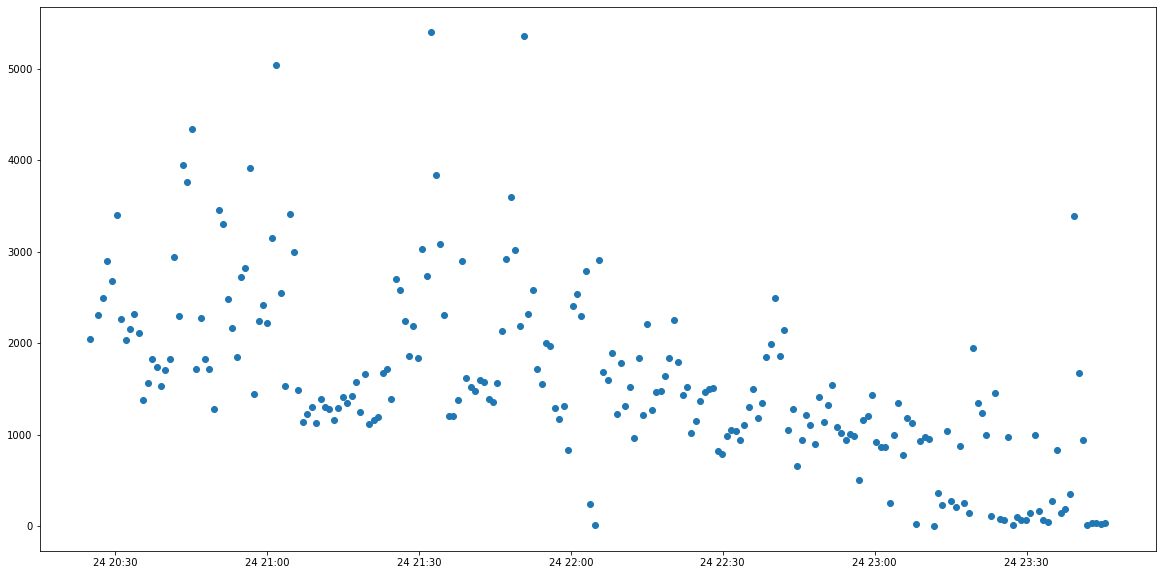

In [16]:
plt.figure(figsize=(20,10))
plt.plot(dates_list,length_list,'o')

In [ ]:
for name,length in zip(name_list,length_list):
    print(name,': ', length/1e3)
    
#TODO split matched route into smaller segments